# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using Turi Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

# Fire up Turi Create

In [1]:
import turicreate

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales = turicreate.SFrame('home_data.sframe/')

# Create new features

In [3]:
sales

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
7129300520,2014-10-13 00:00:00+00:00,221900.0,3.0,1.0,1180.0,5650.0,1.0,0
6414100192,2014-12-09 00:00:00+00:00,538000.0,3.0,2.25,2570.0,7242.0,2.0,0
5631500400,2015-02-25 00:00:00+00:00,180000.0,2.0,1.0,770.0,10000.0,1.0,0
2487200875,2014-12-09 00:00:00+00:00,604000.0,4.0,3.0,1960.0,5000.0,1.0,0
1954400510,2015-02-18 00:00:00+00:00,510000.0,3.0,2.0,1680.0,8080.0,1.0,0
7237550310,2014-05-12 00:00:00+00:00,1225000.0,4.0,4.5,5420.0,101930.0,1.0,0
1321400060,2014-06-27 00:00:00+00:00,257500.0,3.0,2.25,1715.0,6819.0,2.0,0
2008000270,2015-01-15 00:00:00+00:00,291850.0,3.0,1.5,1060.0,9711.0,1.0,0
2414600126,2015-04-15 00:00:00+00:00,229500.0,3.0,1.0,1780.0,7470.0,1.0,0
3793500160,2015-03-12 00:00:00+00:00,323000.0,3.0,2.5,1890.0,6560.0,2.0,0


As in Week 2, we consider features that are some transformations of inputs.

In [4]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [5]:
all_features = ['bedrooms', 'bedrooms_square',
                'bathrooms',
                'sqft_living', 'sqft_living_sqrt',
                'sqft_lot', 'sqft_lot_sqrt',
                'floors', 'floors_square',
                'waterfront', 'view', 'condition', 'grade',
                'sqft_above',
                'sqft_basement',
                'yr_built', 'yr_renovated']

Applying L1 penalty requires adding an extra parameter (`l1_penalty`) to the linear regression call in Turi Create. (Other tools may have separate implementations of LASSO.)  Note that it's important to set `l2_penalty=0` to ensure we don't introduce an additional L2 penalty.

In [6]:
model_all = turicreate.linear_regression.create(sales, 
                                                target = 'price', 
                                                features = all_features,
                                                validation_set = None, 
                                                l2_penalty = 0., 
                                                l1_penalty=1e10)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 17

Number of unpacked features : 17

Number of coefficients    : 18

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

| 0         | 1        | 1.000000  | 1.011899     | 7700000.000000     | 653047.733994                   |

| 1         | 2        | 0.000002  | 1.459200     | 6962915.603493     | 426631.749026                   |

| 2         | 3        | 0.000002  | 1.509342     | 6843144.200219     | 392488.929838                   |

| 3         | 4        | 0.000002  | 1.582254     | 6831900.032123     | 385340.166783                   |

| 4         | 5        | 0.000002  | 1.624970     | 6847166.848958     | 384842.383767                   |

| 5         | 6        | 0.000002  | 1.679382     | 6869667.895833     | 385998.458623                   |

| 10        | 11       | 0.000002  | 1.948702     | 6842123.232651     | 364204.576180                   |

+-----------+----------+-----------+--------------+--------------------+---------------------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Find what features had non-zero weight.

In [7]:
model_all.coefficients.print_rows(num_rows = 18)

+------------------+-------+--------------------+--------+
|       name       | index |       value        | stderr |
+------------------+-------+--------------------+--------+
|   (intercept)    |  None | 274873.0559504957  |  None  |
|     bedrooms     |  None |        0.0         |  None  |
| bedrooms_square  |  None |        0.0         |  None  |
|    bathrooms     |  None | 8468.531086910072  |  None  |
|   sqft_living    |  None | 24.420720982445214 |  None  |
| sqft_living_sqrt |  None | 350.0605533860648  |  None  |
|     sqft_lot     |  None |        0.0         |  None  |
|  sqft_lot_sqrt   |  None |        0.0         |  None  |
|      floors      |  None |        0.0         |  None  |
|  floors_square   |  None |        0.0         |  None  |
|    waterfront    |  None |        0.0         |  None  |
|       view       |  None |        0.0         |  None  |
|    condition     |  None |        0.0         |  None  |
|      grade       |  None | 842.0680348976282  |  None 

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training and test
* Further split our training data into two sets: train, validation

Be *very* careful that you use seed = 1 to ensure you get the same answer!

In [8]:
(training_and_validation, testing) = sales.random_split(.9, seed = 1) 
# initial train/test split
(training, validation) = training_and_validation.random_split(0.5, seed = 1) 
# split training into train and validate

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [9]:
import numpy as np
l1_penalty = np.logspace(1, 7, num = 13)
RSS = list()
for penalty_element in l1_penalty :
    model_train = turicreate.linear_regression.create(training, 
                                                      target = 'price', 
                                                      features = all_features, 
                                                      validation_set = None, 
                                                      l2_penalty = 0, 
                                                      l1_penalty = penalty_element, 
                                                      verbose = False)
    predict_validation_prices = model_train.predict(validation)
    true_validation_prices = validation['price']
    residuals = true_validation_prices - predict_validation_prices
    residuals_square = residuals * residuals
    RSS_element = residuals_square.sum()
    RSS.append(RSS_element)
min_rss_temp = RSS[0]
min_penalty_temp = l1_penalty[0]
for i in range(len(RSS)) :
    if RSS[i] < min_rss_temp :
        min_rss_temp = RSS[i]
        min_penalty_temp = l1_penalty[i]
    else :
        min_rss_temp = min_rss_temp
        min_penalty_temp = min_penalty_temp
print((min_penalty_temp, min_rss_temp))

(10.0, 625766285142459.9)


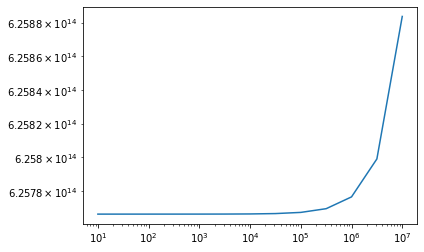

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(l1_penalty, RSS, '-')
plt.xscale('log')
plt.yscale('log')

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [11]:
# l1_penalty = 10.0

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [12]:
model_train_10 = turicreate.linear_regression.create(training, 
                                                  target = 'price', 
                                                  features = all_features, 
                                                  validation_set = None, 
                                                  l2_penalty = 0, 
                                                  l1_penalty = 10.0, 
                                                  verbose = False)
model_train_10.coefficients.print_rows(num_rows = 18)

+------------------+-------+----------------------+--------+
|       name       | index |        value         | stderr |
+------------------+-------+----------------------+--------+
|   (intercept)    |  None |  18993.427212770577  |  None  |
|     bedrooms     |  None |  7936.967679031306   |  None  |
| bedrooms_square  |  None |   936.993368193299   |  None  |
|    bathrooms     |  None |  25409.58893412067   |  None  |
|   sqft_living    |  None |  39.11513637970762   |  None  |
| sqft_living_sqrt |  None |  1124.6502128077207  |  None  |
|     sqft_lot     |  None | 0.003483618222989743 |  None  |
|  sqft_lot_sqrt   |  None |  148.2583910114082   |  None  |
|      floors      |  None |  21204.33546695013   |  None  |
|  floors_square   |  None |  12915.524336072436  |  None  |
|    waterfront    |  None |  601905.5945452718   |  None  |
|       view       |  None |  93312.85731187189   |  None  |
|    condition     |  None |  6609.035712447216   |  None  |
|      grade       |  No

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

In [13]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [14]:
l1_penalty_values = np.logspace(8, 10, num = 20)
# len(l1_penalty_values)

Now, implement a loop that search through this space of possible `l1_penalty` values:

* For `l1_penalty` in `np.logspace(8, 10, num=20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Extract the weights of the model and count the number of nonzeros. Save the number of nonzeros to a list.
        * *Hint: `model.coefficients['value']` gives you an SArray with the parameters you learned.  If you call the method `.nnz()` on it, you will find the number of non-zero parameters!* 

In [15]:
nnz_list = list()
for element in l1_penalty_values :
    model_train = turicreate.linear_regression.create(training, 
                                                      target = 'price', 
                                                      features = all_features, 
                                                      validation_set = None, 
                                                      l2_penalty = 0,
                                                      l1_penalty = element, 
                                                      verbose = False)
    coefficients_array = model_train.coefficients['value']
    nnz_list.append(coefficients_array.nnz())
    # model_train.coefficients.print_rows(num_rows = 18)
    # print(coefficients_array.nnz())
for i in range(len(nnz_list)) :
    print((l1_penalty_values[i], nnz_list[i]))

(100000000.0, 18)
(127427498.57031322, 18)
(162377673.91887242, 18)
(206913808.111479, 18)
(263665089.87303555, 17)
(335981828.6283788, 17)
(428133239.8719396, 17)
(545559478.1168514, 17)
(695192796.1775591, 17)
(885866790.4100832, 16)
(1128837891.6846883, 15)
(1438449888.2876658, 15)
(1832980710.8324375, 13)
(2335721469.0901213, 12)
(2976351441.6313133, 10)
(3792690190.7322536, 6)
(4832930238.571753, 5)
(6158482110.6602545, 3)
(7847599703.514623, 1)
(10000000000.0, 1)


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [16]:
l1_penalty_min = 2976351441.6313133
l1_penalty_max = 3792690190.7322536

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [17]:
l1_penalty_values = np.linspace(l1_penalty_min, l1_penalty_max, 20)
# print(len(l1_penalty_values))
# print(l1_penalty_values)

* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

In [18]:
RSS_conform = list()
penalty_conform = list()
for element in l1_penalty_values :
    model_train = turicreate.linear_regression.create(training, 
                                                      target = 'price', 
                                                      features = all_features, 
                                                      validation_set = None, 
                                                      l2_penalty = 0, 
                                                      l1_penalty = element, 
                                                      verbose = False)
    coefficients_array = model_train.coefficients['value']
    nnz_value = coefficients_array.nnz()
    if nnz_value == max_nonzeros :
        predict_validation_prices = model_train.predict(validation)
        true_validation_prices = validation['price']
        residuals = predict_validation_prices - true_validation_prices
        residuals_square = residuals * residuals
        RSS_conform.append(residuals_square.sum())
        penalty_conform.append(element)
    else :
        continue
rss_min = RSS_conform[0]
penalty_min = penalty_conform[0]
for i in range(len(penalty_conform)) :
    if RSS_conform[i] < rss_min :
        rss_min = RSS_conform[i]
        penalty_min = penalty_conform[i]
    else :
        rss_min = rss_min
        penalty_min = penalty_min
print((penalty_min, rss_min))

(3448968612.163437, 1046937488751711.1)


***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [19]:
model_min_rss = turicreate.linear_regression.create(training, 
                                                    target = 'price', 
                                                    features = all_features, 
                                                    validation_set = None, 
                                                    l2_penalty = 0,
                                                    l1_penalty = penalty_min, 
                                                    verbose = False)
model_min_rss.coefficients.print_rows(num_rows = 18)

+------------------+-------+--------------------+--------+
|       name       | index |       value        | stderr |
+------------------+-------+--------------------+--------+
|   (intercept)    |  None | 222253.19254432785 |  None  |
|     bedrooms     |  None | 661.7227177822587  |  None  |
| bedrooms_square  |  None |        0.0         |  None  |
|    bathrooms     |  None | 15873.957259267981 |  None  |
|   sqft_living    |  None | 32.41022145125964  |  None  |
| sqft_living_sqrt |  None | 690.1147733133256  |  None  |
|     sqft_lot     |  None |        0.0         |  None  |
|  sqft_lot_sqrt   |  None |        0.0         |  None  |
|      floors      |  None |        0.0         |  None  |
|  floors_square   |  None |        0.0         |  None  |
|    waterfront    |  None |        0.0         |  None  |
|       view       |  None |        0.0         |  None  |
|    condition     |  None |        0.0         |  None  |
|      grade       |  None | 2899.4202697498786 |  None 